In [87]:
# Import data from /dataset/

import pandas as pd

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

In [88]:
df.head()

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment
0,1532325760148590593,@xbresson British Alps :-),replied_to,62044012,False,0,0,1,2,33022,3383,5246,359,"['british', 'alps']",0.0000,neutral
1,1312410689059913731,RT @Aistats2020: Videos presentations of paper...,retweeted,1290762290224984064,False,52,0,0,0,17570,541,703,222,"['videos', 'presentations', 'papers', 'keynote...",0.0000,neutral
2,1564467011781926913,I hope I would be able to talk more about this...,quoted,3363584909,False,1,0,0,3,65506,113,15406,856,"['hope', 'would', 'able', 'talk', 'balcony', '...",0.4862,neutral
3,1473395733344788481,RT @dlbcnai: Keynote by Joan Bruna (@joanbruna...,retweeted,1071640880,False,35,0,0,0,21847,555,1346,264,"['keynote', 'joan', 'bruna', 'geometric', 'dee...",0.3612,neutral
4,1611495430843502593,@annargrs @Michael_J_Black @AllenHW0 @CSProfKG...,replied_to,48008938,False,0,0,1,5,427851,582,12949,6488,"['process', 'science', 'relies', 'much', 'basi...",-0.3182,neutral


In [89]:
# Count the number of dataset
df.count()

id                    8000
text                  8000
type                  8000
author_id             8000
possibly_sensitive    8000
retweet_count         8000
quote_count           8000
reply_count           8000
like_count            8000
followers_count       8000
following_count       8000
tweet_count           8000
listed_count          8000
words                 8000
score_compound        8000
sentiment             8000
dtype: int64

In [90]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [91]:
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']


num_total = len(df)
num_pos = len(df_pos)
num_neu = len(df_neu)
num_neg = len(df_neg)

print(f"Num. positive tweets: {num_pos} ({num_pos/num_total*100:.2f}%)")
print(f"Num. negative tweets: {num_neg} ({num_neg/num_total*100:.2f}%)")
print(f"Num. neutral tweets: {num_neu} ({num_neu/num_total*100:.2f}%)")


Num. positive tweets: 2228 (27.85%)
Num. negative tweets: 482 (6.02%)
Num. neutral tweets: 5290 (66.12%)


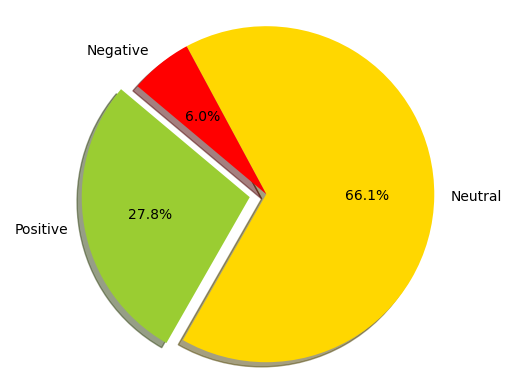

In [92]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot the sentiments in a pie chart

labels = ['Positive', 'Neutral', 'Negative']

sizes = [num_pos, num_neu, num_neg]

colors = ['yellowgreen', 'gold', 'red']

explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


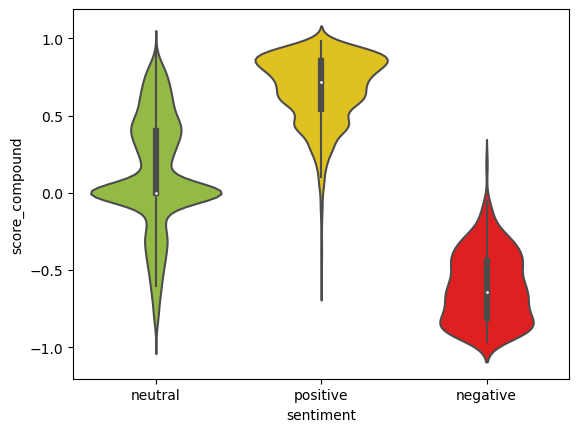

In [93]:
# Import seaborn
import seaborn as sns

# Plot violinplot

plt.close('all')

sns.violinplot(data=df, x='sentiment', y='score_compound', palette=colors)
plt.show()

In [94]:
from sentence_transformers import SentenceTransformer

# Specify the model name
# I downloaded in models directory three models: 
# all-MiniLM-L6-v2(Fastest but smalles), stsb-roberta-base-v2(middle), and stsb-mpnet-base-v2(Slowest, but best performance)

name = 'all-mpnet-base-v2'

# Load the SentenceTransformer model
model = SentenceTransformer(f'models/{name}')


No sentence-transformers model found with name models/all-mpnet-base-v2. Creating a new one with MEAN pooling.


Extra link for model rankings:
https://www.sbert.net/docs/pretrained_models.html

In [95]:
# List of sentences to get embeddings for
sentences = list(df.words_str.values)

# Get the sentence embeddings
sentence_embeddings = model.encode(sentences)

# save the embeddings
import numpy as np
np.save(f'embeddings/{name}_train.npy', sentence_embeddings)

In [96]:
# load locally saved embeddings
sentence_embeddings = np.load(f'embeddings/{name}_train.npy')

Regression

In [97]:
#define some functions for plotting purposes

def plot_y_continous(y, bins=10, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.hist(y, bins=bins)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

def plot_scatter(x, y,  show=True, x_label=None, y_label=None,  title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.scatter(x,y)
    if isinstance(title, str):
        ax.set_title(title)
    if isinstance(x_label, str):
        ax.set_xlabel(x_label)
    if isinstance(y_label, str):
        ax.set_ylabel(y_label)
    plt.tight_layout()
    if show: plt.show()
    

In [98]:
#create X (feature matrix) and y (targets)
X = sentence_embeddings
y = df.score_compound.values
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (8000, 768)
y: (8000,)


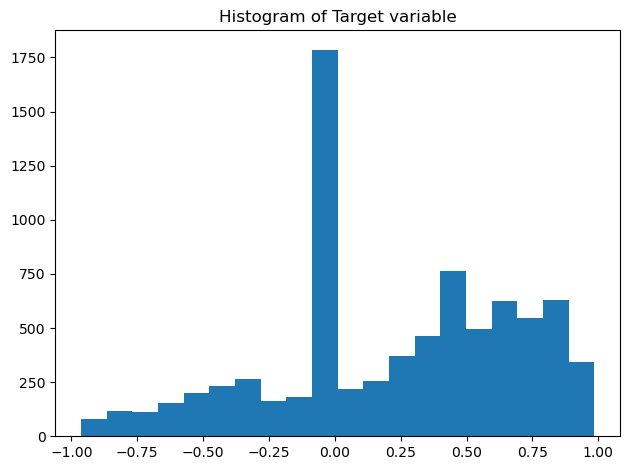

In [99]:
plt.close('all')
plot_y_continous(y, bins=20, title='Histogram of Target variable')

In [100]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import numpy as np

In [103]:
#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]


In [104]:
from sklearn import linear_model
#create our linear regression model
reg = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
# train the model
reg = reg.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")
    


Split: train
	RMSE: 0.33
	MAE: 0.26
	R2: 0.48

Split: valididation
	RMSE: 0.36
	MAE: 0.28
	R2: 0.34


In [ ]:
#plot the histogram of learnt weights w_i 
plot_y_continous(reg.coef_, bins=20, title='Histogram of Parameters (w) learnt')

In [106]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

#create our SVR model
reg = make_pipeline(SVR(kernel='rbf', C=0.8, gamma='scale', epsilon=.1))
# train the model
print('Training...')
reg = reg.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")

Training...

Split: train
	RMSE: 0.16
	MAE: 0.12
	R2: 0.87

Split: valididation
	RMSE: 0.34
	MAE: 0.27
	R2: 0.41


For test data

In [108]:
# Run this to save a file with your predictions on the test set to be submitted
sentences_test = list(df_test.words_str.values)
X_test = model.encode(sentences_test)
y_hat = reg.predict(X_test)

In [109]:
# Save the results with the format <TEAM_ID>__<SPLIT>_reg_pred.npy
import os

directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__reg_pred.npy'), y_hat)

Classification

In [110]:
from sklearn import linear_model
from sklearn import preprocessing

In [111]:
def plot_y_discrete(y, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    sns.countplot(x=y, palette=colors, ax=ax)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

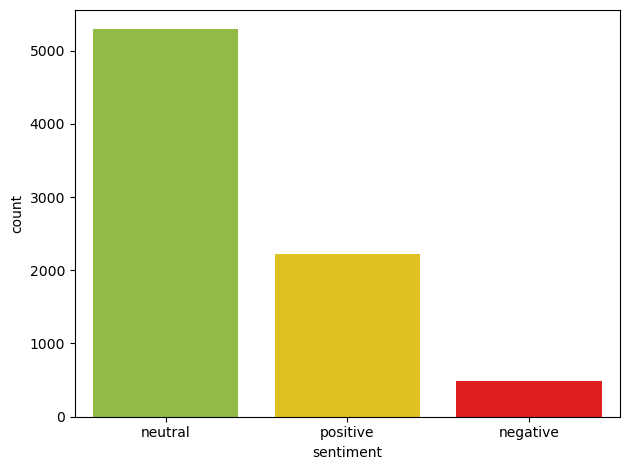

In [112]:
plot_y_discrete(df.sentiment)

In [113]:
# data preprocessing
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (8000, 768)
y: (8000,) [0 1 2]


In [114]:
# handle class imbalancea
from imblearn.over_sampling import RandomOverSampler, SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# logistic regression model
clf = linear_model.LogisticRegression(penalty=None, 
                                      dual=False, 
                                      tol=0.0001, 
                                      C=1.0, 
                                      fit_intercept=True, 
                                      intercept_scaling=1, 
                                      class_weight=None, # None, balanced
                                      random_state=None, 
                                      solver='lbfgs',  
                                      multi_class='auto', 
                                      verbose=0, 
                                      warm_start=False, 
                                      n_jobs=None, 
                                      l1_ratio=None,
                                      max_iter=10000
                                     )
clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

Training...

Split: train
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       395
           1       1.00      1.00      1.00      4200
           2       1.00      1.00      1.00      1805

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400


Split: validation
              precision    recall  f1-score   support

           0       0.23      0.13      0.16        87
           1       0.76      0.89      0.82      1090
           2       0.65      0.42      0.51       423

    accuracy                           0.72      1600
   macro avg       0.55      0.48      0.50      1600
weighted avg       0.70      0.72      0.70      1600

ROC AUC: {0: 0.8112260789631621, 1: 0.7223187623673323, 2: 0.7522771963018532}


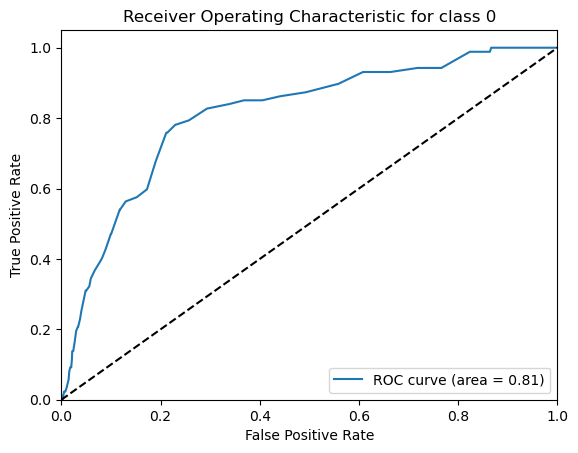

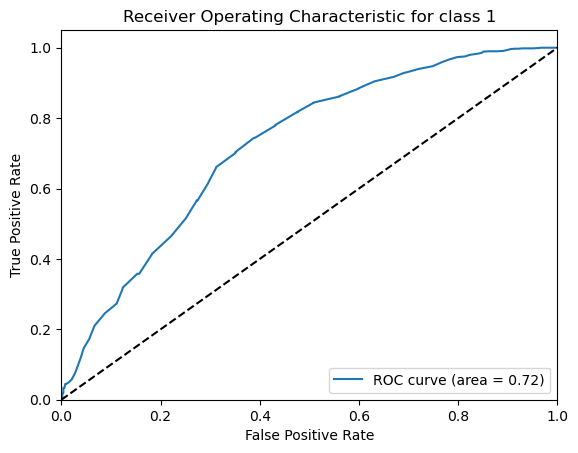

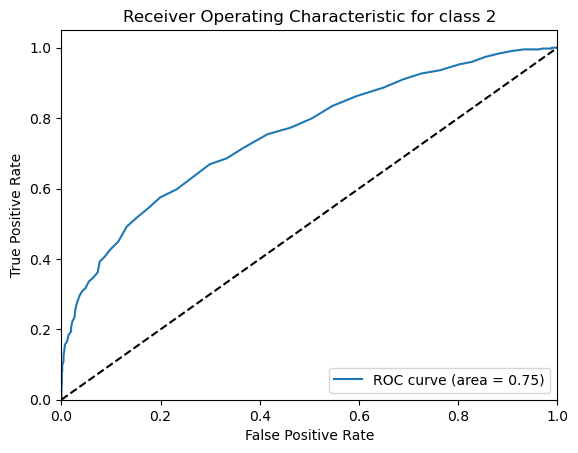

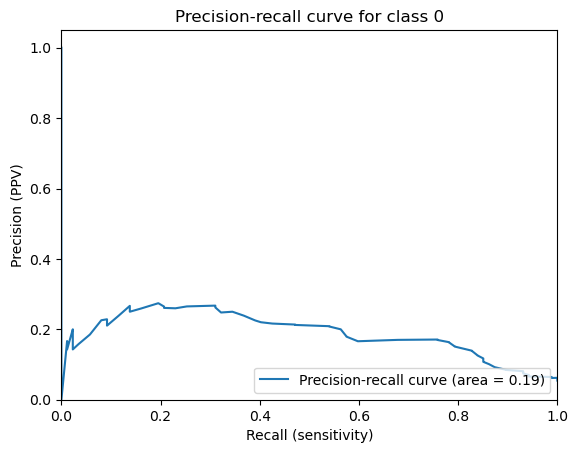

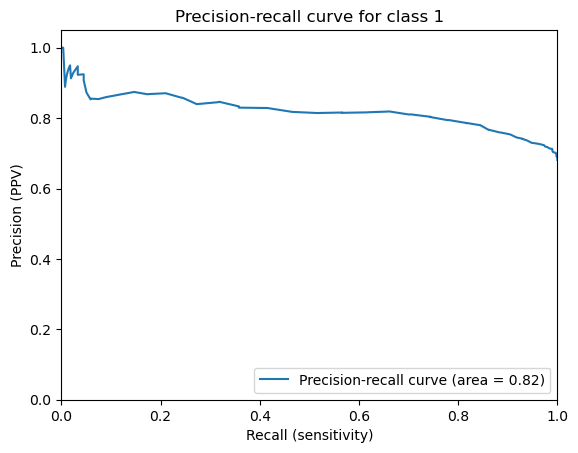

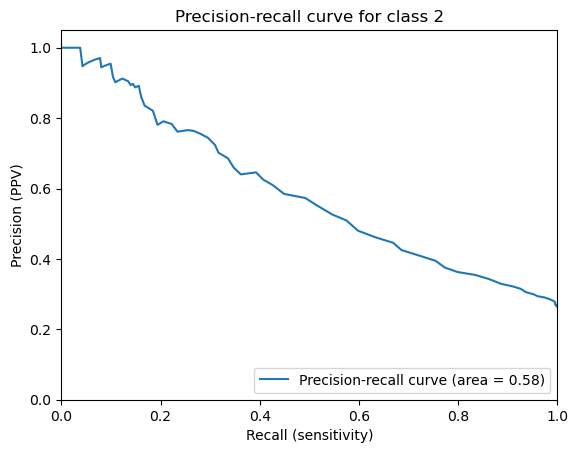

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# random forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
# train the model
print('Training...')
clf = clf.fit(X_train, y_train)

# evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

# binariaze the labels
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
num_classes = y_val_bin.shape[1]
# predict the probabilities for each class
y_pred_bin = clf.predict_proba(X_val)

# compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(f'ROC AUC: {roc_auc}')
# plot the ROC curve
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class %i' % i)
    plt.legend(loc="lower right")
    plt.show()

# compute the precision-recall curve and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], y_pred_bin[:, i])
# plot the precision-recall curve
for i in range(num_classes):
    plt.figure()
    plt.plot(recall[i], precision[i], label='Precision-recall curve (area = %0.2f)' % average_precision[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title('Precision-recall curve for class %i' % i)
    plt.legend(loc="lower right")
    plt.show()


In [116]:
# Run this to save a file with your predictions on the test set to be submitted
sentences_test = list(df_test.words_str.values)
X_test = model.encode(sentences_test)
y_hat = clf.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy

directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__clf_pred.npy'), y_hat)